In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mon-reader/images/training/notflip/0036_000000026.jpg
/kaggle/input/mon-reader/images/training/notflip/0044_000000017.jpg
/kaggle/input/mon-reader/images/training/notflip/0004_000000024.jpg
/kaggle/input/mon-reader/images/training/notflip/0035_000000029.jpg
/kaggle/input/mon-reader/images/training/notflip/0041_000000005.jpg
/kaggle/input/mon-reader/images/training/notflip/0032_000000024.jpg
/kaggle/input/mon-reader/images/training/notflip/0005_000000004.jpg
/kaggle/input/mon-reader/images/training/notflip/0045_000000001.jpg
/kaggle/input/mon-reader/images/training/notflip/0026_000000017.jpg
/kaggle/input/mon-reader/images/training/notflip/0057_000000025.jpg
/kaggle/input/mon-reader/images/training/notflip/0035_000000031.jpg
/kaggle/input/mon-reader/images/training/notflip/0033_000000013.jpg
/kaggle/input/mon-reader/images/training/notflip/0058_000000023.jpg
/kaggle/input/mon-reader/images/training/notflip/0041_000000031.jpg
/kaggle/input/mon-reader/images/training/notflip

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
batch_size = 32
img_height = 256
img_width = 256

train_dir = '/kaggle/input/mon-reader/images/training'

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.5,
    subset="training",
    seed=123,
    color_mode='rgb',
    crop_to_aspect_ratio=True,
    label_mode='binary',
    shuffle=True,
    image_size=(img_height, img_width),
    batch_size=batch_size)

test_dir = '/kaggle/input/mon-reader/images/testing'

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.5,
    subset="validation",
    seed=123,
    color_mode='rgb',
    crop_to_aspect_ratio=True,
    label_mode='binary',
    shuffle=True,
    image_size=(img_height, img_width),
    batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=123,
    color_mode='rgb',
    crop_to_aspect_ratio=True,
    label_mode='binary',
    shuffle=False,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2392 files belonging to 2 classes.
Using 1196 files for training.


I0000 00:00:1752355613.797128      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752355613.797784      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 2392 files belonging to 2 classes.
Using 1196 files for validation.
Found 597 files belonging to 2 classes.


In [3]:
class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

Classes: ['flip', 'notflip']


In [4]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
class_names

['flip', 'notflip']

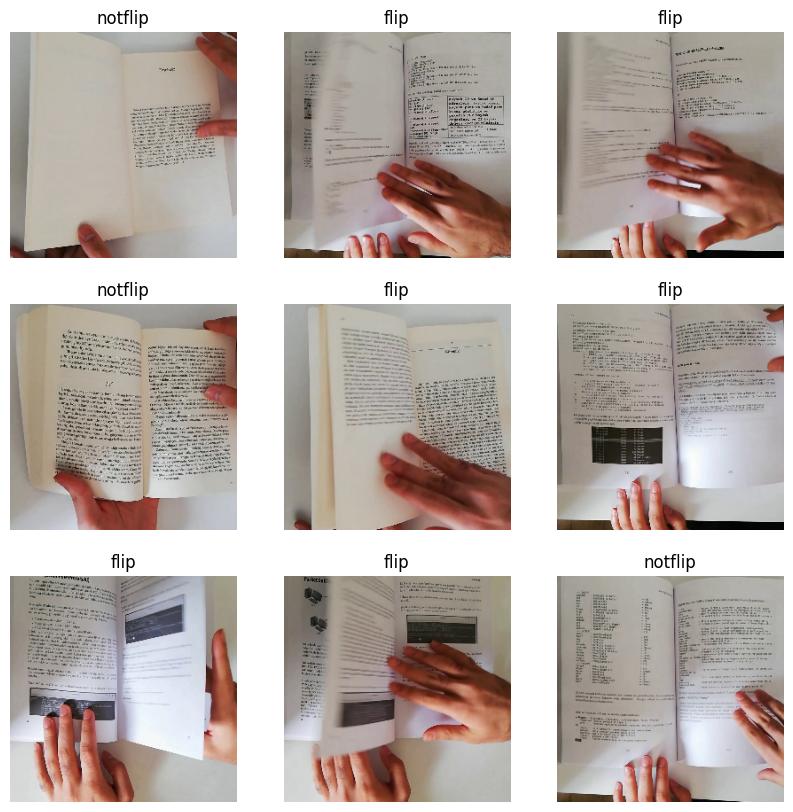

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        # print(labels.numpy())
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels.numpy().astype("uint8")[i][0]])
        plt.axis("off")

In [35]:
def to_one_hot(x, y):
    return x, tf.one_hot(y, depth=num_classes)

train_ds = train_ds.map(to_one_hot)
val_ds   = val_ds.map(to_one_hot)
test_ds  = test_ds.map(to_one_hot)

In [56]:
from tensorflow.keras.models import Sequential

img_size = (img_height, img_width)

cnn = Sequential([
    layers.Rescaling(1./255, input_shape=(*img_size, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

cnn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

cnn.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │       7,372,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,466,177 (28.48 MB)

 Trainable params: 7,466,177 (28.48 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.5454 - loss: 0.8373 - precision: 0.5461 - recall: 0.6567 - val_accuracy: 0.5284 - val_loss: 0.6856 - val_precision: 0.6453 - val_recall: 0.1808
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.6698 - loss: 0.6576 - precision: 0.7109 - recall: 0.6264 - val_accuracy: 0.7818 - val_loss: 0.5175 - val_precision: 0.7638 - val_recall: 0.8322
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.7964 - loss: 0.4678 - precision: 0.7937 - recall: 0.8302 - val_accuracy: 0.8562 - val_loss: 0.3126 - val_precision: 0.9108 - val_recall: 0.7980
Epoch 4/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.9000 - loss: 0.2779 - precision: 0.8847 - recall: 0.9329 - val_accuracy: 0.9356 - val_loss: 0.1724 - val_precision: 0.9228 - val_recall: 0.9544
Epoch 5/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.9483 - loss: 0.1499 - precision: 0.9364 - recall: 0.9676 - val_accuracy: 0.9130 - val_loss: 0.198

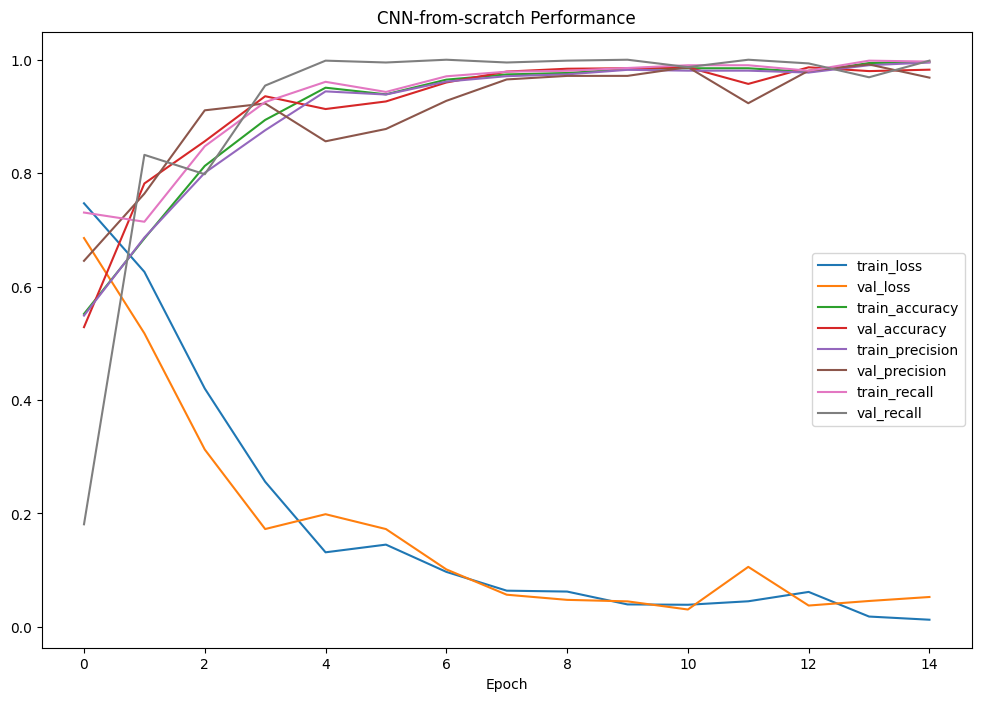

In [57]:
history_cnn = cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15
)

import matplotlib.pyplot as plt

def plot_metrics(hist, title):
    metrics = ['loss','accuracy','precision','recall']
    plt.figure(figsize=(12,8))
    for m in metrics:
        plt.plot(hist.history[m], label=f'train_{m}')
        plt.plot(hist.history['val_'+m], label=f'val_{m}')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

plot_metrics(history_cnn, "CNN-from-scratch Performance")

In [58]:
cnn.evaluate(test_ds, verbose=2, return_dict=True)

19/19 - 3s - 133ms/step - accuracy: 0.9648 - loss: 0.1052 - precision: 0.9360 - recall: 1.0000


{'accuracy': 0.9648241400718689,
 'loss': 0.10518253594636917,
 'precision': 0.9359756112098694,
 'recall': 1.0}

In [13]:
from datasets import load_dataset

train_dir = "/kaggle/input/mon-reader/images/training/"
test_dir = "/kaggle/input/mon-reader/images/testing/"

ds = load_dataset(
    "imagefolder",
    data_dir="/kaggle/input/mon-reader/images/training",  # root containing 'training/' & 'test/'
    split=None
)
print(ds)

Resolving data files:   0%|          | 0/2392 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2392
    })
})


In [14]:
from datasets import load_dataset

# ds = load_dataset(
#     "imagefolder",
#     data_dir="/kaggle/input/mon-reader/images",
#     split={
#         "train":      "training[:80%]",
#         "validation": "training[80%:]",
#         "test":       "testing"    
#     }
# )

# print(ds)

Resolving data files:   0%|          | 0/2392 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/597 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

ValueError: Unknown split "training". Should be one of ['train', 'test'].

In [20]:
from datasets import load_dataset

# 1) Tell the ImageFolder builder exactly where to find your images
data_files = {
    "train": "/kaggle/input/mon-reader/images/training/*/*",
    "test":  "/kaggle/input/mon-reader/images/testing/*/*"
}

dataset = load_dataset(
    "imagefolder",
    data_files=data_files,
    cache_dir="/tmp/hf_cache"
)

print(dataset)  

print("Classes:", dataset["train"].features["label"].names)
# e.g. ['flipping', 'not_flipping']

split = dataset["train"].train_test_split(test_size=0.5, seed=42)

train_ds      = split["train"]
validation_ds = split["test"]
test_ds       = dataset["test"]

print("→ train rows:",      len(train_ds))
print("→ validation rows:", len(validation_ds))
print("→ test rows:",       len(test_ds))

Resolving data files:   0%|          | 0/2392 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/597 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2392
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 597
    })
})
Classes: ['flip', 'notflip']
→ train rows: 1196
→ validation rows: 1196
→ test rows: 597
